# model Prediction ResNet18+MLP

# Importations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split
import matplotlib.pyplot as plt

# Class pour preparation data

In [2]:

class ECGDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        
        self.tabular_features = ["age", "sex", "height", "weight"]
        self.targets = [
            "P_Amp_V1", "P_Amp_II", "P_Amp_I", "P_Dur_Global", "PR_Int_Global",
            "QT_IntFramingham_Global", "S_Amp_Global", "PQ_Int_Global", 
            "QRS_Dur_Global", "RR_Mean_Global", "QT_Int_Global"
        ]

        # Normalisation des données tabulaires (standardisation)
        self.scaler = StandardScaler()
        self.data[self.tabular_features] = self.scaler.fit_transform(self.data[self.tabular_features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = row["filename_lr"].split("/")[-1] + ".png"
        img_path = os.path.join(self.img_dir, filename)

        if not os.path.exists(img_path):
            print(f"⚠️ Image non trouvée: {img_path}")
            return None
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        tabular_data = torch.tensor(row[self.tabular_features].values.astype(float), dtype=torch.float32)
        target = torch.tensor(row[self.targets].values.astype(float), dtype=torch.float32)

        return image, tabular_data, target


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])


# class pour la definition du modele

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class ECGModel(nn.Module):
    def __init__(self):
        super(ECGModel, self).__init__()
        # Utiliser ResNet18 
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 256)

        self.mlp = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 11)
        )

    def forward(self, image, tabular):
        x1 = self.resnet(image)
        x2 = self.mlp(tabular)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x




# fonction loss personnalisé pour l'inversion de signe 

In [4]:
class SignSensitiveMSELoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(SignSensitiveMSELoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        mse_loss = nn.MSELoss()(predictions, targets)
        sign_mismatch_penalty = self.alpha * torch.mean((torch.sign(predictions) != torch.sign(targets)).float())
        return mse_loss + sign_mismatch_penalty

# preparation test et train loader

In [5]:
import os
import torch
from torch.utils.data import DataLoader, random_split

def prepare_data(csv_path, img_dir, batch_size=32):
    # Créer l'instance originale du dataset pour pouvoir récupérer le scaler
    original_dataset = ECGDataset(csv_path, img_dir, transform=transform)
    
    # Filtrer les échantillons invalides
    dataset = [data for data in original_dataset if data is not None]
    if len(dataset) == 0:
        print("❌ Aucun fichier image valide trouvé. Vérifiez votre dossier !")
        return None, None, None, None
    
    # Définir les tailles de splits
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    # Découper le dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Créer les DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Récupérer le scaler utilisé dans le dataset original
    scaler = original_dataset.scaler
    
    return train_loader, val_loader, test_loader, scaler


# fonction d'entrainement 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(train_loader, val_loader, num_epochs=50, lr=0.001, weight_decay=5e-4, patience=7):
    model = ECGModel()
    criterion = SignSensitiveMSELoss(alpha=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, targets in train_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, tabular_data, targets in val_loader:
                images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
                outputs = model(images, tabular_data)
                val_loss = criterion(outputs, targets)
                running_val_loss += val_loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"🛑 Early stopping triggered at epoch {epoch+1}")
                break
    
    print("✅ Entraînement terminé !")
    return model, train_losses, val_losses


# entrainement du modéle

In [7]:

csv_path = "ecg_mesures_equilibred2.csv"
img_dir = "image_back_blanc"


# Préparation des données et récupération des DataLoader et du scaler
train_loader, val_loader, test_loader, scaler = prepare_data(csv_path, img_dir, batch_size=32)

# Entraînement du modèle
model, train_losses, val_losses = train_model(train_loader, val_loader, num_epochs=100, lr=0.001)

# Tu peux ensuite utiliser test_loader pour l'évaluation et scaler pour la normalisation lors de l'inférence



⚠️ Image non trouvée: image_back_blanc\13119_lr.png


c:\Users\yomna\anaconda3\envs\PT\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yomna\anaconda3\envs\PT\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\yomna\anaconda3\envs\PT\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100] - Train Loss: 15930.9051 | Val Loss: 2031.7507
Epoch [2/100] - Train Loss: 1999.3415 | Val Loss: 2387.5421
Epoch [3/100] - Train Loss: 1961.0565 | Val Loss: 1800.3335
Epoch [4/100] - Train Loss: 1682.6721 | Val Loss: 1644.9592
Epoch [5/100] - Train Loss: 1283.4026 | Val Loss: 1035.6685
Epoch [6/100] - Train Loss: 1080.2782 | Val Loss: 1382.7588
Epoch [7/100] - Train Loss: 955.6766 | Val Loss: 900.4759
Epoch [8/100] - Train Loss: 913.2706 | Val Loss: 1270.9197
Epoch [9/100] - Train Loss: 891.1502 | Val Loss: 2618.9392
Epoch [10/100] - Train Loss: 821.4808 | Val Loss: 753.3376
Epoch [11/100] - Train Loss: 799.4843 | Val Loss: 1016.7369
Epoch [12/100] - Train Loss: 776.5117 | Val Loss: 734.1316
Epoch [13/100] - Train Loss: 748.0507 | Val Loss: 1093.6328
Epoch [14/100] - Train Loss: 735.1574 | Val Loss: 2025.0483
Epoch [15/100] - Train Loss: 699.5379 | Val Loss: 752.2901
Epoch [16/100] - Train Loss: 657.0790 | Val Loss: 839.4063
Epoch [17/100] - Train Loss: 593.5334 | Val Los

# evaluation du modéle 

In [8]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Épochs')
    plt.ylabel('Loss')
    plt.title('Courbes de Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


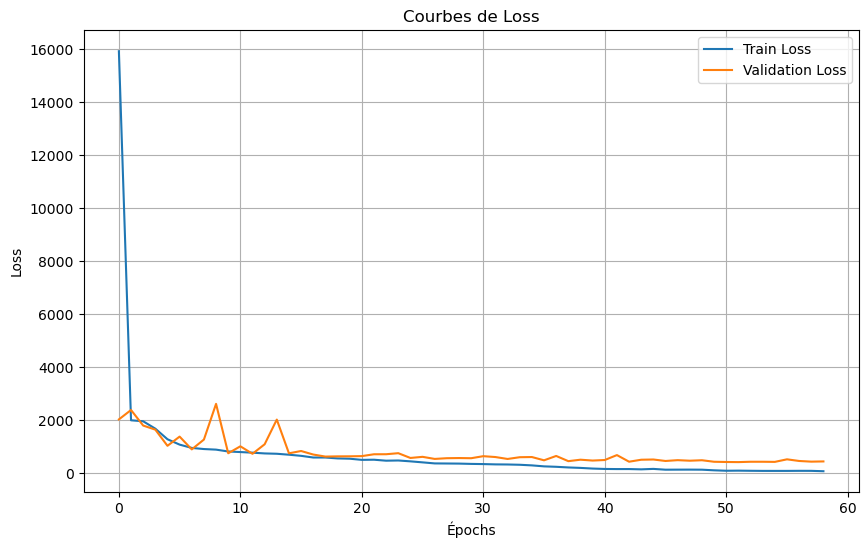

In [9]:
plot_loss_curves(train_losses, val_losses)

In [10]:
import torch
import torch.nn as nn
import numpy as np

def calcul_metric(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Mode évaluation
    
    mse_loss_fn = nn.MSELoss()  # Pour MSE et RMSE
    mae_loss_fn = nn.L1Loss()   # Pour MAE

    total_mse = 0.0
    total_mae = 0.0
    total_r2 = 0.0  # Pour le R²
    total_rmse = 0.0
    total_smape = 0.0
    total_sign_mismatch = 0.0  # Pourcentage d'inversions de signe
    num_batches = 0

    epsilon = 1e-8  # Pour éviter la division par zéro

    with torch.no_grad():  # Pas de calcul de gradients
        for images, tabular_data, targets in test_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)

            outputs = model(images, tabular_data)

            # Calcul des métriques classiques
            mse = mse_loss_fn(outputs, targets).item()
            mae = mae_loss_fn(outputs, targets).item()
            rmse = np.sqrt(mse)
            
            # SMAPE (Symmetric Mean Absolute Percentage Error)
            smape = torch.mean(2 * torch.abs(targets - outputs) / (torch.abs(targets) + torch.abs(outputs) + epsilon)) * 100

            # Calcul du R² (Coefficient de détermination)
            ss_tot = torch.sum((targets - torch.mean(targets, dim=0)) ** 2)
            ss_res = torch.sum((targets - outputs) ** 2)
            r2 = 1 - (ss_res / ss_tot).item()

            # Calcul du pourcentage d'inversions de signe
            sign_mismatch = torch.mean((torch.sign(outputs) != torch.sign(targets)).float()).item() * 100

            # Accumuler les métriques
            total_mse += mse
            total_mae += mae
            total_r2 += r2
            total_rmse += rmse
            total_smape += smape.item()
            total_sign_mismatch += sign_mismatch

            num_batches += 1

    # Moyennes sur tous les batches
    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    avg_r2 = total_r2 / num_batches
    avg_rmse = total_rmse / num_batches
    avg_smape = total_smape / num_batches
    avg_sign_mismatch = total_sign_mismatch / num_batches

    # Affichage des résultats
    print("\n📊 **Résultats de l'évaluation :**")
    print(f"🔹 MSE (Mean Squared Error) : {avg_mse:.4f}")
    print(f"🔹 RMSE (Root Mean Squared Error) : {avg_rmse:.4f}")
    print(f"🔹 MAE (Mean Absolute Error) : {avg_mae:.4f}")
    print(f"🔹 SMAPE (Symmetric Mean Absolute Percentage Error) : {avg_smape:.2f}%")
    print(f"🔹 R² (Coefficient de Détermination) : {avg_r2:.4f}")
    print(f"🔹 Inversions de signe : {avg_sign_mismatch:.2f}%")
    
    return avg_mse, avg_rmse, avg_mae, avg_smape, avg_r2, avg_sign_mismatch

# Lancer l'évaluation après l'entraînement
if model:
    calcul_metric(model, test_loader)



📊 **Résultats de l'évaluation :**
🔹 MSE (Mean Squared Error) : 424.4554
🔹 RMSE (Root Mean Squared Error) : 20.3309
🔹 MAE (Mean Absolute Error) : 11.2324
🔹 SMAPE (Symmetric Mean Absolute Percentage Error) : 50.86%
🔹 R² (Coefficient de Détermination) : 0.9113
🔹 Inversions de signe : 13.38%


# sauvgarde

In [11]:
import joblib

# Définir le dossier de sauvegarde
output_dir = "model_pred"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Sauvegarder le modèle (state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.save(model.state_dict(), os.path.join(output_dir, "ecg_model_back_blanc.pth"))

# Sauvegarder le scaler
joblib.dump(scaler, os.path.join(output_dir, "scaler_back_blanc.pkl"))

print("Modèle et scaler sauvegardés dans le dossier 'model_pred'.")

Modèle et scaler sauvegardés dans le dossier 'model_pred'.


# prediction et comparaison

Indices des 5 meilleures prédictions (score le plus bas) : [ 878 1287  653 1134 1226]

📊 Comparaison des valeurs pour l'échantillon 878 (Score: 2.5332)
                      Label  Valeur Réelle  Valeur Prédite
0                  P_Amp_V1         0.0400          0.2453
1                  P_Amp_II         0.0400          0.0113
2                   P_Amp_I        -0.0350         -0.0136
3              P_Dur_Global       170.0000        168.7570
4             PR_Int_Global       230.0000        229.0826
5   QT_IntFramingham_Global       423.8900        421.6876
6              S_Amp_Global        -0.1088         -0.3336
7             PQ_Int_Global       174.0000        174.4734
8            QRS_Dur_Global       162.0000        146.5743
9            RR_Mean_Global       706.0000        699.9442
10            QT_Int_Global       377.0000        375.9326

📊 Comparaison des valeurs pour l'échantillon 1287 (Score: 2.9848)
                      Label  Valeur Réelle  Valeur Prédite
0             

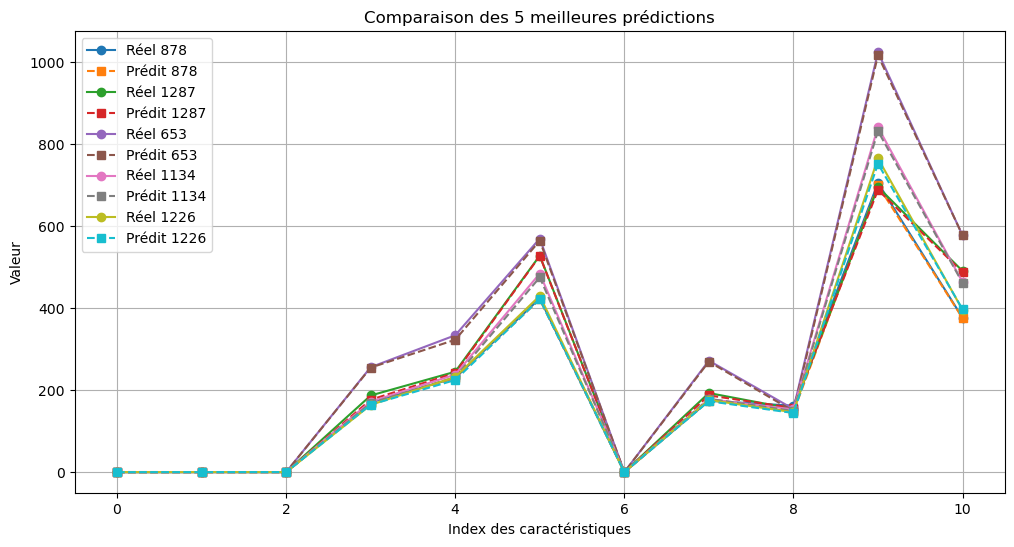

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, tabular_data, targets in test_loader:
            images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
            outputs = model(images, tabular_data)
            
            # Si le modèle est multi-head et retourne un tuple, on concatène les sorties
            if isinstance(outputs, tuple):
                outputs = torch.cat(outputs, dim=1)
                
            y_pred.append(outputs.cpu().numpy())
            y_true.append(targets.cpu().numpy())

    # Fusionner toutes les prédictions et cibles
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    
    # Calcul de l'erreur moyenne absolue (MAE) par échantillon
    sample_errors = np.mean(np.abs(y_pred - y_true), axis=1)
    
    # Vérifier pour chaque échantillon que tous les signes concordent
    sign_match = np.all(np.sign(y_pred) == np.sign(y_true), axis=1)
    
    # Pour les échantillons avec inversion de signe, on ajoute une pénalité élevée
    penalty = 1000  # Pénalité importante pour écarter ces échantillons
    sample_scores = np.where(sign_match, sample_errors, sample_errors + penalty)
    
    # Récupérer les indices des 5 meilleurs échantillons (score le plus bas)
    best_indices = np.argsort(sample_scores)[:5]
    print("Indices des 5 meilleures prédictions (score le plus bas) :", best_indices)
    
    # Liste des labels ECG pour l'affichage
    ecg_labels = ['P_Amp_V1', 'P_Amp_II', 'P_Amp_I', 'P_Dur_Global', 'PR_Int_Global',
                  'QT_IntFramingham_Global', 'S_Amp_Global', 'PQ_Int_Global', 
                  'QRS_Dur_Global', 'RR_Mean_Global', 'QT_Int_Global']
    
    # Affichage sous forme de tableau pour chaque échantillon sélectionné
    for idx in best_indices:
        example_true = y_true[idx]
        example_pred = y_pred[idx]
        df_comparaison = pd.DataFrame({
            "Label": ecg_labels,
            "Valeur Réelle": example_true,
            "Valeur Prédite": example_pred
        })
        pd.set_option("display.float_format", "{:.4f}".format)
        print(f"\n📊 Comparaison des valeurs pour l'échantillon {idx} (Score: {sample_scores[idx]:.4f})")
        print(df_comparaison)
    
    # Affichage graphique des 5 meilleurs exemples
    plt.figure(figsize=(12, 6))
    for idx in best_indices:
        plt.plot(y_true[idx], marker='o', linestyle='-', label=f"Réel {idx}")
        plt.plot(y_pred[idx], marker='s', linestyle='--', label=f"Prédit {idx}")
    plt.xlabel("Index des caractéristiques")
    plt.ylabel("Valeur")
    plt.title("Comparaison des 5 meilleures prédictions")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return y_true, y_pred, best_indices

# Exemple d'utilisation :
if model:
    y_true, y_pred, best_indices = evaluate_model(model, test_loader)


In [ ]:
# df=pd.read_csv("ecg_mesures_equilibred2.csv")
# df[(df['P_Amp_V1']==0.0200)&(df['P_Amp_II']==-0.0900)] .head(1)

,ecg_id,age,sex,height,weight,filename_lr,P_Amp_V1,P_Amp_II,P_Amp_I,P_Dur_Global,PR_Int_Global,QT_IntFramingham_Global,S_Amp_Global,PQ_Int_Global,QRS_Dur_Global,RR_Mean_Global,QT_Int_Global
4019,14270,23.0000,1,175.0000,65.0000,records100/14000/14270_lr,0.0200,-0.0900,0.0350,210.0000,271.0000,453.1200,-0.0737,217.0000,154.0000,724.0000,408.0000


In [19]:
import pandas as pd
import torch

# Liste des labels correspondant aux 11 sorties du modèle
labels = [
    "P_Amp_V1", "P_Amp_II", "P_Amp_I", "P_Dur_Global", "PR_Int_Global",
    "QT_IntFramingham_Global", "S_Amp_Global", "PQ_Int_Global",
    "QRS_Dur_Global", "RR_Mean_Global", "QT_Int_Global"
]

def afficher_predictions_exemples(model, data_loader, n_exemples=5):
    model.eval()
    device = next(model.parameters()).device  # Utilise le device du modèle
    # Récupérer un premier batch
    sample = next(iter(data_loader))
    images, tabular_data, targets= sample
    images, tabular_data, targets = images.to(device), tabular_data.to(device), targets.to(device)
    
    with torch.no_grad():
        outputs = model(images, tabular_data)
    
    # Limiter le nombre d'exemples si le batch en contient moins
    n = min(n_exemples, images.size(0))
    
    for i in range(n):
        true_values = targets[i].cpu().numpy()
        pred_values = outputs[i].cpu().numpy()
        
        # Création de la DataFrame pour l'affichage
        data = {
            "Label": labels,
            "Valeur Réelle": [f"{v:.4f}" for v in true_values],
            "Valeur Prédite": [f"{v:.4f}" for v in pred_values]
        }
        df = pd.DataFrame(data)
        
        print(f"📊 Exemple {i+1} :")
        print(df)
        print("\n")

# Exemple d'utilisation avec le DataLoader de validation (val_loader)
afficher_predictions_exemples(model, val_loader,n_exemples=20)

📊 Exemple 1 :
                      Label Valeur Réelle Valeur Prédite
0                  P_Amp_V1       -0.0200        -0.2310
1                  P_Amp_II        0.0050        -0.0986
2                   P_Amp_I        0.0050        -0.0305
3              P_Dur_Global      200.0000       213.2834
4             PR_Int_Global      274.0000       279.5093
5   QT_IntFramingham_Global      543.7900       575.5046
6              S_Amp_Global       -0.3621        -0.2629
7             PQ_Int_Global      220.0000       222.1992
8            QRS_Dur_Global      173.0000       157.0589
9            RR_Mean_Global     1236.0000      1234.6854
10            QT_Int_Global      588.0000       613.4316


📊 Exemple 2 :
                      Label Valeur Réelle Valeur Prédite
0                  P_Amp_V1       -0.0900         0.0145
1                  P_Amp_II        0.0900         0.0228
2                   P_Amp_I        0.0100         0.0618
3              P_Dur_Global      208.0000       212.8228
4

# preduction reel

In [14]:
import os
import joblib
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import transforms
from PIL import Image

def single_prediction(model, image_path, tabular_data, scaler, device):
    """
    Fonction pour effectuer une prédiction sur une image avec des données tabulaires associées.

    Arguments:
        model (nn.Module): Modèle entraîné.
        image_path (str): Chemin de l'image à prédire.
        tabular_data (list): Données tabulaires associées à l'image (ex: âge, sexe, etc.).
        scaler (scaler): Le scaler utilisé pour normaliser les données tabulaires.
        device (torch.device): Le périphérique pour exécuter les calculs (CPU ou GPU).

    Retourne:
        pd.DataFrame: DataFrame avec les prédictions du modèle pour chaque caractéristique.
    """
    # Charger et transformer l'image
    transform_pred = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionner à la taille attendue par le modèle
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalisation
    ])

    image = Image.open(image_path).convert("RGB")  # Charger l'image et convertir en RGB
    image_tensor = transform_pred(image).unsqueeze(0).to(device)  # Ajouter une dimension de batch et envoyer sur le bon device

    # Appliquer le scaler aux données tabulaires (normalisation)
    tabular_data = np.array(tabular_data).reshape(1, -1)  # Reshaper les données pour correspondre à la forme attendue par le scaler
    tabular_data = scaler.transform(tabular_data)  # Appliquer la transformation (normalisation)
    tabular_data = torch.tensor(tabular_data, dtype=torch.float32).to(device)  # Convertir en tenseur et envoyer sur le bon device

    # Mettre le modèle en mode évaluation
    model.eval()
    
    with torch.no_grad():
        # Faire la prédiction en utilisant l'image et les données tabulaires
        prediction = model(image_tensor, tabular_data).cpu().numpy().flatten()

    # Labels correspondant aux différentes sorties
    labels = [
        "P_Amp_V1", "P_Amp_II", "P_Amp_I", "P_Dur_Global", "PR_Int_Global",
        "QT_IntFramingham_Global", "S_Amp_Global", "PQ_Int_Global",
        "QRS_Dur_Global", "RR_Mean_Global", "QT_Int_Global"
    ]

    # Créer un DataFrame avec les résultats
    df_results = pd.DataFrame({"Label": labels, "Valeur prédite": prediction})

    return df_results


In [15]:

# ==============================
# Exemple d'utilisation en inférence
# ==============================
# Charger le modèle et le scaler sauvegardés
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = ECGModel()
loaded_model.load_state_dict(torch.load(os.path.join(output_dir, "ecg_model.pth"), map_location=device))
loaded_model.to(device)
loaded_model.eval()

loaded_scaler = joblib.load(os.path.join(output_dir, "scaler.pkl"))

# Test de prédiction
test_image_path = r'D:\ECG_data\records100\00001_lr.png'  # Remplacer avec ton image
test_tabular_data = [56.0, 1,0.0, 63.0]  # Exemple de données tabulaires [âge, sexe, taille, poids]

# Effectuer la prédiction sur l'image
df_result = single_prediction(loaded_model, test_image_path, test_tabular_data, loaded_scaler, device)

# Afficher les résultats
print(df_result.head(11))


c:\Users\yomna\anaconda3\envs\PT\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yomna\anaconda3\envs\PT\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\yomna\AppData\Local\Temp\ipykernel_30112\4232155737.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/

FileNotFoundError: [Errno 2] No such file or directory: 'model_pred\\ecg_model.pth'

In [ ]:

# Test de prédiction
test_image_path = r'D:\ECG_data\Mbarka_Mekni.jpg'  # Remplacer avec ton image
test_tabular_data = [74.0,1,168.0, 70.0]  # Exemple de données tabulaires [âge, sexe, taille, poids]

# Effectuer la prédiction sur l'image
df_result = single_prediction(loaded_model, test_image_path, test_tabular_data, loaded_scaler, device)

# Afficher les résultats
print(df_result.head(11))


c:\Users\pc\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pc\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\pc\AppData\Local\Temp\ipykernel_14332\593201333.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#unt

                      Label  Valeur prédite
0                  P_Amp_V1        0.036398
1                  P_Amp_II        0.049588
2                   P_Amp_I        0.085079
3              P_Dur_Global      187.912628
4             PR_Int_Global      259.404999
5   QT_IntFramingham_Global      541.251953
6              S_Amp_Global       -0.059577
7             PQ_Int_Global      201.647507
8            QRS_Dur_Global      162.066528
9            RR_Mean_Global      838.310547
10            QT_Int_Global      517.532837


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


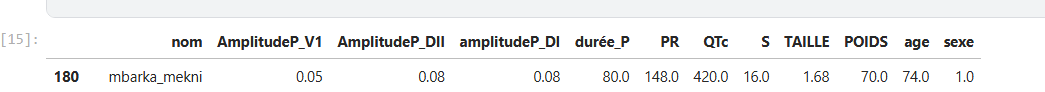